In [5]:
from time import time 

from tools import *
from multi_factor import * 
from K_shift import *

**Goal.** Simulate trajectories of $X_t = \displaystyle\int_0^t K(t-s)\, dW_s$, for $t \in [0,T]$, with $K(t) = K^\text{shift}(t) = (t+\varepsilon)^{H-\frac12}$, $\varepsilon = 1/52$.

**Multifactor approximation.** As in `K_frac.ipynb`, the idea is to approximate the fractional kernel by a finite sum of exponentials:
\begin{align*}
    K^{\text{shift}}(t) \approx \widetilde{K}^{\text{shift}}(t) = \sum_{j=1}^{n_{\text{fact}}} \alpha_j e^{-\gamma_j t}, \qquad (\alpha_j)_{j=1,\ldots, n_{\text{fact}}},\, (\gamma_j)_{j=1,\ldots, n_{\text{fact}}} \in \mathbb{R}_+^{n_{\text{fact}}}.
\end{align*}

<div style="border:solid 1px; border-radius:8px; padding: 6px 8px 6px 8px; margin-top: 12px; border-color:rgb(0, 62, 92, 0.5); background-color:rgb(251, 251, 251);"> 
    <strong>Remark.</strong> This approximation is justified by the fact that shifted fractional kernel is completely monotone on $(0,\infty)$.
Recall that a function $K : (0,\infty) \longmapsto \mathbb{R}$ is said to be completely monotone if
$$(-1)^k K^{(k)}(t) \ge 0,
\qquad \forall t > 0,\; \forall k \ge 0.$$
By Bernstein’s theorem, complete monotonicity is equivalent to the existence of a positive measure $\mu$ on $\mathbb{R}_+$ such that
$$K(t) = \int_0^\infty e^{-x t}\, \mu(dx).$$
</div>   

Using this approximation, the Volterra process $X$ can be written as
$$X_t \approx \sum_{j=1}^{n_{\mathrm{fact}}} \alpha_j X_t^{(j)},
\qquad
X_t^{(j)} := \int_0^t e^{-\gamma_j (t-s)}\, dW_s.$$
For each $j \in \{1,\ldots,n_{\mathrm{fact}}\}$, the process $(X_t^{(j)})_{t \ge 0}$ is an Ornstein–Uhlenbeck process (hence a semimartingale), satisfying
$$dX_t^{(j)} = -\gamma_j X_t^{(j)}\, dt + dW_t,
\qquad
X_0^{(j)} = 0.$$

**Naive scheme.** Let us compare the multifactor approximation with the following naive scheme: 
\begin{equation} X_{t_i} \approx \sqrt{\frac{T}{n}}\sum_{j=0}^{i-1} (t_i - t_j + \varepsilon)^{H-1/2} Y_{j}, \end{equation}
with $(Y_j)_{j=0,\ldots, n-1} \overset{\text{iid}}{\sim} \mathcal N(0,1)$. The above quantitty is calculated in an optimized way via (Fast Fourier Transform) FFT.

In [7]:
M = 10000
n = 600
T = 0.1
n_factors = 15
eps = 1/52
Z = simulate_antithetic(M, n) 
t_grid = np.linspace(0, T, n+1)

### I. Naive scheme

#### I.1. $H = -0.1$

In [11]:
H = -0.1

In [15]:
start = time() 
X_minus_01 = simulate_X_shift_FFT(M, n, T, H, eps, Z)
print("Time : ", time() - start) 

Time :  0.24878740310668945


#### I.2. $H = 0.1$

In [18]:
H = 0.1

In [20]:
start = time() 
X_01 = simulate_X_shift_FFT(M, n, T, H, eps, Z)
print("Time : ", time() - start) 

Time :  0.24333977699279785


### II. Multifactor approximation

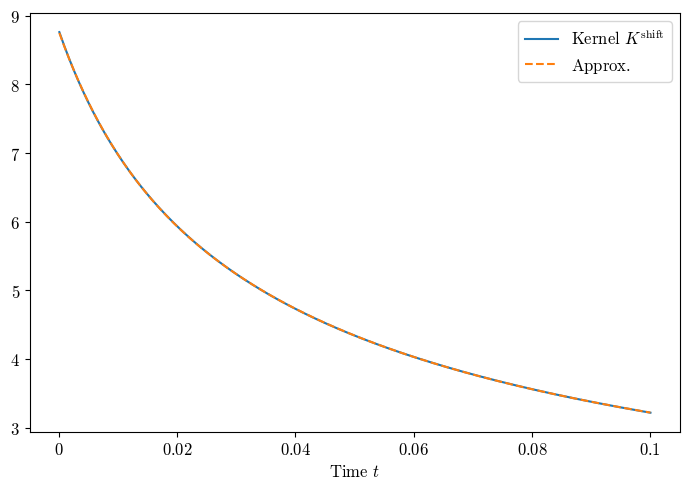

In [23]:
H = -0.05
t, y, alpha_i, gamma_i = fit_K_shift(n_factors, H, T, display=True)

#### II.1. $H = -0.1$

In [26]:
H = -0.1

In [30]:
start = time() 
t, _, alpha_i, gamma_i = fit_K_shift(n_factors, H, T, n)
X_fact_minus_01 = simulate_X_multifactor(M, n, n_factors, T, alpha_i, gamma_i, Z)
print("Temps : ", time() - start) 

Temps :  0.7704520225524902


#### II.2. $H = 0.1$

In [33]:
H = 0.1

In [38]:
start = time() 
t, _, alpha_i, gamma_i = fit_K_shift(n_factors, H, T, n)
X_fact_01 = simulate_X_multifactor(M, n, n_factors, T, alpha_i, gamma_i, Z)
print("Temps : ", time() - start) 

Temps :  0.3436551094055176


### III. Joint plot 

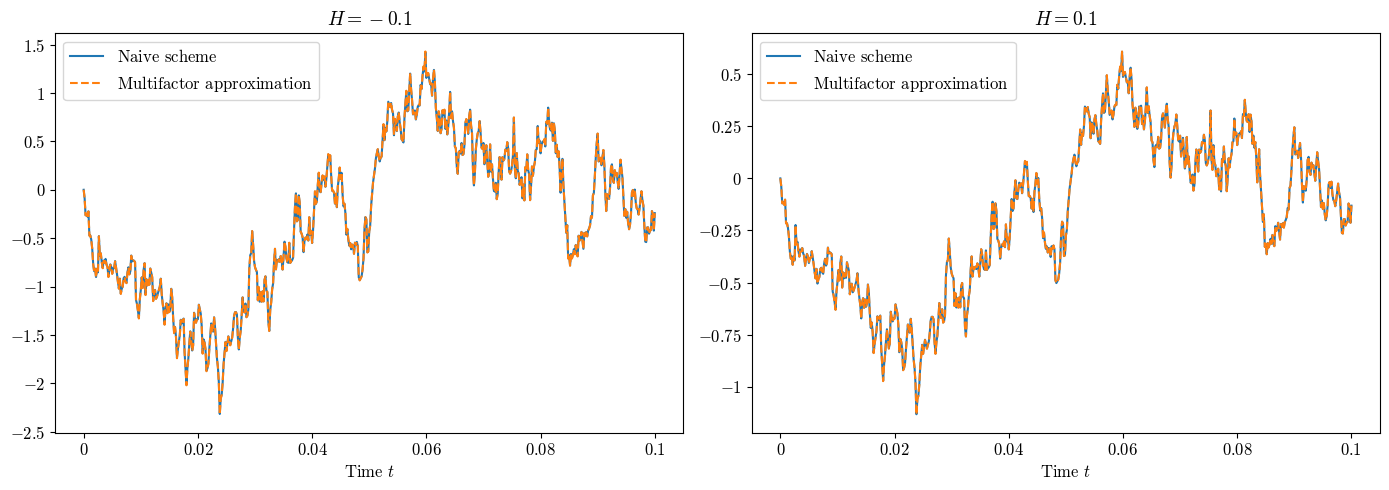

In [41]:
fig, ax = plt.subplots(1, 2, figsize = (14,5))

m_test = 2 

ax[0].plot(t_grid, X_minus_01[m_test,:], label = r"$\text{Naive scheme}$")
ax[0].plot(t_grid, X_fact_minus_01[m_test,:], linestyle ="--", label = r"$\text{Multifactor approximation}$")
ax[0].set_title(r"$H = -0.1$", fontsize=14)

ax[1].plot(t_grid, X_01[m_test,:], label = r"$\text{Naive scheme}$")
ax[1].plot(t_grid, X_fact_01[m_test,:], linestyle ="--", label = r"$\text{Multifactor approximation}$")
ax[1].set_title(r"$H = 0.1$", fontsize=14)

for i in range(2) : 
    ax[i].set_xlabel(r"$\text{Time }t$", fontsize=12)
    ax[i].tick_params(axis='both', labelsize=12)
    ax[i].xaxis.set_major_formatter(lambda x, _: f"${x:g}$")
    ax[i].yaxis.set_major_formatter(lambda y, _: f"${y:g}$")
    ax[i].legend(loc="best", fontsize=12)

plt.tight_layout()
plt.show()